# Convolutional Neural Network classifier evaluation
This notebook can be used to evaluate performance of different variants of a CNN classifier. In order to run run it you must have:
- trained some new classifiers that you want to evaluate
- run the paycheck cross-validation on all of those
- stored the results of all cross-validations in one directory (specified below)

In terms of code execution, you should have run:
- `paycheck_generate_folds` to prepare the train/test datasets used in the next step (for a _k_ number of folds)
- `paycheck_cv_classifier` to cross-validate the classifiers _k_-times (exact specs for every classifier can be passed as an argument to that method)

Following the cross-validation step, you should end up with a directory structure similar to this:
```
project_dir/
  |
  +--sample-type-1/
  |   |
  |   +--results/
  |   |   |
  |   |   +--abundance/
  |   |   +--expected/
  |   |   +--relative_frequencies/
  |   |   +--CNN/
  |   |       |
  |   |       +--class-weights-1/
  |   |       +--class-weights-2/
  |   |       +--class-weights-3/
  |   +--tmp/
  |       |
  |       +--fold-0/
  |       +--fold-1/
  |       +--fold-k/
  +--sample-type-2/
```
where `sample-type-1/2` is the type of the sample on which you want to perform the analysis (e.g. sediment-non-saline) and `class-weights-1/2/3` indicates your specifc classifiers that should be evaluated. You should indicate the correct `project_dir` and `sample_type` in the cells below. Paths to `class-weights` should be discovered automatically, given the directory structure above (that means you'll probably need to move some files around).

## Imports and required function definitions

In [1]:
import os
import json

from joblib import Parallel, delayed
import qiime2
import biom
import numpy as np
import pandas as pd
import swifter
import seaborn as sns
from qiime2.plugins import feature_table
from qiime2.plugins import taxa
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem

from q2_quality_control._evaluate_taxonomy import _evaluate_taxonomy
from q2_quality_control._utilities import (
    _evaluate_composition, _compute_per_level_accuracy, _match_samples_by_index, _drop_nans_zeros)

%matplotlib inline

In [2]:
def _calc_prf(exp_taxa, obs_taxa, table):
    # calculate weighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=table,
        sample_id=None)
    prf['method'] = 'weighted'
    prf_results = prf

    # calculate unweighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=None,
        sample_id=None)
    prf['method'] = 'unweighted'
    prf_results = pd.concat([prf_results, prf])
    
    return prf_results


def _collapse_frequency_table_to_relative_frequency(table, taxonomy, level=7):
    for level in range(level, 0, -1):
        # to cater for truncated classifications
        try:
            table_l7 = taxa.methods.collapse(table=table, level=level, taxonomy=taxonomy)
            break
        except ValueError as e:
#             raise e
            pass
    rel_freq = feature_table.methods.relative_frequency(table_l7.collapsed_table)
    obs_table = rel_freq.relative_frequency_table.view(pd.DataFrame)
    return obs_table


def _eval_comp_basic(exp, obs, depth=7):
    exp, obs = _match_samples_by_index(exp, obs)

    # DROP NANS/ZERO ABUNDANCE FEATURES
    obs = _drop_nans_zeros(obs)
    exp = _drop_nans_zeros(exp)

    for depth in range(depth, 0, -1):
        # TAR/TDR for obs vs. exp at each level
        try:
            results, vectors = _compute_per_level_accuracy(exp, obs, metadata=None, depth=depth)
            break
        except ValueError:
            pass
    return results


def _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp):
    table_fp = os.path.join(frequencies_dir, fn)
    table = qiime2.Artifact.load(table_fp)
    rel_freq = feature_table.methods.relative_frequency(table)
    rel_freq.relative_frequency_table.save(rel_freq_fp)
    table = rel_freq.relative_frequency_table.view(biom.Table)
    return table


def _eval_for_class_weights(
    cw, type_dir, expected_dir, fns, frequencies_dir, relative_frequencies_dir):
    prf_results = pd.DataFrame()
    eval_results = pd.DataFrame()
    if cw == sample_type:
        return prf_results, eval_results

    cw_dir = os.path.join(type_dir, cw)
    # evaluate taxonomy
    for fn in fns:
        if fn in ['log', 'log_missed']:
            continue
        sample, _ = os.path.splitext(fn)

        # convert table to relative frequencies
        rel_freq_fp = os.path.join(relative_frequencies_dir, fn)
        if not os.path.exists(rel_freq_fp):
            table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)
        else:
            try:
                table = qiime2.Artifact.load(rel_freq_fp).view(biom.Table)
            except Exception as e:
                print(
                    f"An exception has occurred: {e}. Will try to recreate artifact."
                )
                table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)

        # load data
        exp_taxa_fp = os.path.join(expected_dir, fn)
        exp_taxa = qiime2.Artifact.load(exp_taxa_fp).view(pd.DataFrame)
        obs_taxa_fp = os.path.join(cw_dir, fn)
        obs_taxa = qiime2.Artifact.load(obs_taxa_fp).view(pd.DataFrame)

        results = _calc_prf(exp_taxa, obs_taxa, table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        prf_results = pd.concat([prf_results, results])

        # evaluate composition
        table_fp = os.path.join(frequencies_dir, fn)
        table = qiime2.Artifact.load(table_fp)
        try:
            exp_table = _collapse_frequency_table_to_relative_frequency(
                table, qiime2.Artifact.load(exp_taxa_fp))
            obs_table = _collapse_frequency_table_to_relative_frequency(
                table, qiime2.Artifact.load(obs_taxa_fp))
            print("No problem with:", exp_taxa_fp)
        except Exception as e:
            print("Problem with:", exp_taxa_fp)
            raise e

        results = _eval_comp_basic(exp_table, obs_table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        eval_results = pd.concat([eval_results, results])

    return prf_results, eval_results

def _check_sample_type(fns, df, class_weights, sample_type, is_prf=False):
    if len(df) == 0:
        return fns
    type_and_weight = df[df['sample type'] == sample_type]['sample']
    for_eval = []
    for fn in fns:
        levels = sum(type_and_weight == fn[:-4])
        m = 2 if is_prf else 1
        assert levels == 0 or levels == 7*m*(len(class_weights) - 1), \
            'got partial record for ' + fn
        if levels == 0:
            for_eval.append(fn)
    return for_eval

def _get_params_from_model(model_name):
    name_split = model_name.split('-')
    model_name = name_split[0]
    confidence, model_suffix = np.nan, 'none'
    if len(name_split) > 1:
        try:
            if float(name_split[1]) <= 1.0:
                confidence = float(name_split[1])
            else:
                model_suffix = name_split[1]
        except ValueError:
            model_suffix = name_split[1]
    if (model_name == 'nb' or model_name.startswith('Ben')) and np.isnan(confidence):
        confidence = 0.7
    if len(name_split) > 2:
        model_suffix = name_split[2]
    return model_name, confidence, model_suffix

def generate_model_label(row):
    filt = str(int(row['filters'])) if not row['filters'] == 'none' else 'none'
    kern = str(int(row['kernel_size'])) if not row['kernel_size'] == 'none' else 'none'
    conf = str(row['confidence']) if not row['confidence'] == 'none' else 'none'
    suffix = str(row['model suffix']) if not row['model suffix'] == 'none' else 'none'
    label = '-'.join([row['model name'], filt, kern, suffix, conf])
    return label

def plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, y_lims, palette, save_loc=None):
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(24, 5)

        # calculate mean metric for each fold by grouping by model
        # reset index to unstack all the levels from the multi-level index for easy plotting
        grouped_level7 = data.groupby(['class weights', 'model name', 'level', 'confidence', 'fold', 'model suffix', 'model labels'] + params)
        axis_data = grouped_level7.apply(weighted_stats, **{"metric": metric}).reset_index()
        axis_data.sort_values(["confidence"] + params, ascending=True, inplace=True)

        # sort by confidence to plot in confidence groups
        all_models = axis_data["model labels"].unique()
        all_models_sorted = sorted(all_models, key=lambda x: x.split("-")[-1])

        # set proper colours per model name
        base_colors = sns.color_palette(palette, len(axis_data["model name"].unique()))
        unique_models = sorted(list(set([x.split("-")[0] for x in all_models_sorted])))
        color_palette = [base_colors[unique_models.index(x)] for x in [y.split("-")[0] for y in all_models_sorted]]

        g = sns.boxplot(x="model labels", y=metric, data=axis_data, ax=axes, palette=color_palette, order=all_models_sorted)

        # set custom y ticks
        
        if y_lims:
            g.set_ylim(y_lims)
        if y_ticks_major:
            g.yaxis.set_ticks(np.arange(y_ticks_major[0], y_ticks_major[1], 0.1))
        if y_ticks_minor:
            minor_locator = AutoMinorLocator(2)
            g.yaxis.set_minor_locator(minor_locator)
            g.tick_params(which='minor', length=4)
            g.grid(True, which='minor', axis='y')

        # set some font sizes
        g.yaxis.label.set_size(15)
        for tick in g.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in g.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
            tick.label.set_rotation(90)

        if save_loc:
            fig.savefig(save_loc, dpi=300)

        plt.show()
        
        return axis_data

def calculate_aggregate_metrics(axis_data, metric, grouping_column):
    axis_data_grouped = axis_data[[metric, grouping_column]].groupby(grouping_column)
    metric_table = pd.concat([axis_data_grouped.mean(), axis_data_grouped.sem(), axis_data_grouped.count()], axis=1)
    metric_table.columns = [f"Avg {metric}", "SEM", "Count"]
    return metric_table

def weighted_stats(x, metric):
    d1 = DescrStatsW(x[metric], weights=x['abundance'])
    return pd.Series([d1.mean], index=[metric])

## Data sources and sample types
In order to run the analyses below, update the path to where your data is located (`project_dir`). Also, indicate which sample types you want to use in the analysis (corresponding directories need to exist within your project directory). Class weights paths will be discovered automatically - you should see them below.

In [3]:
project_dir = os.path.expandvars('/Users/mziemski/feature_classifier_paper/data/eval_cnn')
sample_types = ['animal-distal-gut']

In [4]:
from glob import glob

class_weights = []
for path in glob(os.path.join(project_dir, 'animal-distal-gut', 'results', 'CNN', '*')):
    class_weights.append('/'.join(path.split('/')[-2:]))

In [5]:
class_weights

['CNN/ModelX-0.5']

## Run the evaluation

#### Evaluate cross-validation results or read the evaluation from file.

In [6]:
if os.path.exists(os.path.join(project_dir, 'eval_comp_results.tsv')):
    eval_comp_results = pd.read_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
else:
    eval_comp_results = pd.DataFrame()
if os.path.exists(os.path.join(project_dir, 'eval_taxa_prf.tsv')):
    prf_results = pd.read_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    prf_results = pd.DataFrame()

if not eval_comp_results.shape[0] > 0 and not prf_results.shape[0] > 0:
    print("Evaluating classification results...")
    for sample_type in sample_types:
        type_results = pd.DataFrame()
        type_dir = os.path.join(project_dir, sample_type, 'results')
        expected_dir = os.path.join(type_dir, 'expected')
        fns = os.listdir(expected_dir)
        frequencies_dir = os.path.join(type_dir, 'abundance')
        relative_frequencies_dir = os.path.join(type_dir, 'relative_frequencies')
        if not os.path.exists(relative_frequencies_dir):
            os.makedirs(relative_frequencies_dir)

        results = Parallel(n_jobs=4, verbose=50, batch_size=1)(
            delayed(_eval_for_class_weights)(
                cw, type_dir, expected_dir, fns, 
                frequencies_dir, relative_frequencies_dir) 
            for cw in class_weights)

        prf_list, eval_list = zip(*results)
        prf_results = pd.concat([prf_results] + list(prf_list))
        eval_comp_results = pd.concat([eval_comp_results] + list(eval_list))
        
        eval_comp_results.to_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
        prf_results.to_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    print("Evaluation results were loaded from a file.")

Evaluation results were loaded from a file.


In [7]:
print("Evaluation results shape:", eval_comp_results.shape, "and columns:", eval_comp_results.columns)
print("PRF results shape:", prf_results.shape)

Evaluation results shape: (1458412, 16) and columns: Index(['sample', 'level', 'Observed Taxa', 'Observed / Expected Taxa', 'TAR',
       'TDR', 'Slope', 'Intercept', 'r-value', 'P value', 'Std Err',
       'Bray-Curtis', 'Jaccard', 'r-squared', 'class weights', 'sample type'],
      dtype='object')
PRF results shape: (2917376, 8)


In [8]:
prf_results["class weights"].unique()

array(['Model4-0.95', 'Model2-0.95', 'Model1-0.7', 'Model9-0.7', 's2v',
       'Model6-0.7', 'Model3-0.5', 'Model8-0.7', 'Model10-0.7',
       'Model1-0.5', 'Model1-0.95', 'Model2-0.5', 'Model7-0.7',
       'Model12-0.7', 'keras-test', 'Model3-0.7', 'nb', 'lr-0.7',
       'Model5-0.7', 'Model3-0.95', 'Model2-0.7', 'Model11-0.7',
       'Model4-0.5', 'Model4-0.7', 'nb-150', 'Model4-0.25-10',
       'Model4-0.5-10', 'Model6-0.25-10', 'Model6-0.5-10', 'Ben4', 'Ben9',
       'Model6-0.25-20', 'Ben9-20', 'Model6-sg', 'NaiveBayes/nb-0.25',
       'NaiveBayes/nb-0.5', 'NaiveBayes/nb-0.95'], dtype=object)

In [9]:
prf_results.head(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample
0,1,1.0,0.968763,0.984134,weighted,Model4-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696
1,2,1.0,0.956457,0.977744,weighted,Model4-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696


In [10]:
# load the new models
additional_prfs = pd.read_csv("/Users/mziemski/feature_classifier_paper/data/eval_cnn/keras-extra/eval_taxa_prf_keras_extra.tsv", sep="\t", index_col=0)[prf_results.columns]

In [11]:
additional_prfs.head(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample
0,1,0.989182,0.989182,0.989182,weighted,ModelX-0.5,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696
1,2,0.984432,0.983367,0.983899,weighted,ModelX-0.5,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696


In [12]:
# merge both dfs
print(prf_results.shape, additional_prfs.shape)
prf_results = pd.concat([prf_results, additional_prfs])
print(prf_results.shape)

(2917376, 8) (315392, 8)
(3232768, 8)


In [13]:
# clean up some stray columns (all starting with "Unnamed" - probably DF index that was repeatedly saved to file)
cols_to_keep = [col for col in eval_comp_results.columns if not col.startswith('Unnamed')]
eval_comp_results_clean = eval_comp_results[cols_to_keep]

# rename some NaiveBayes models that were added later
eval_comp_results_clean.loc[eval_comp_results_clean["class weights"].str.startswith("NaiveBayes/"), "class weights"] = eval_comp_results_clean.loc[eval_comp_results_clean["class weights"].str.startswith("NaiveBayes/"), "class weights"].apply(lambda x: x.split("/")[-1])
prf_results.loc[prf_results["class weights"].str.startswith("NaiveBayes/"), "class weights"] = prf_results.loc[prf_results["class weights"].str.startswith("NaiveBayes/"), "class weights"].apply(lambda x: x.split("/")[-1])

cols_to_keep = [col for col in prf_results.columns if not col.startswith('Unnamed')]
prf_results_clean = prf_results[cols_to_keep]
prf_results_clean["model name"], prf_results_clean["confidence"], prf_results_clean["model suffix"] = zip(
    *prf_results_clean["class weights"].apply(_get_params_from_model))

# save as a backup
eval_comp_results_clean.to_csv(os.path.join(project_dir, 'eval_comp_results_cleaned.tsv'), sep='\t')
prf_results_clean.to_csv(os.path.join(project_dir, 'eval_taxa_prf_cleaned.tsv'), sep='\t')

print(eval_comp_results_clean.shape, prf_results_clean.shape)

(1458412, 16) (3232768, 11)


In [14]:
prf_results_clean['class weights'].unique()

array(['Model4-0.95', 'Model2-0.95', 'Model1-0.7', 'Model9-0.7', 's2v',
       'Model6-0.7', 'Model3-0.5', 'Model8-0.7', 'Model10-0.7',
       'Model1-0.5', 'Model1-0.95', 'Model2-0.5', 'Model7-0.7',
       'Model12-0.7', 'keras-test', 'Model3-0.7', 'nb', 'lr-0.7',
       'Model5-0.7', 'Model3-0.95', 'Model2-0.7', 'Model11-0.7',
       'Model4-0.5', 'Model4-0.7', 'nb-150', 'Model4-0.25-10',
       'Model4-0.5-10', 'Model6-0.25-10', 'Model6-0.5-10', 'Ben4', 'Ben9',
       'Model6-0.25-20', 'Ben9-20', 'Model6-sg', 'nb-0.25', 'nb-0.5',
       'nb-0.95', 'ModelX-0.5', 'ModelY-0.5', 'ModelZ-0.5',
       'ModelAlpha-0.5'], dtype=object)

#### Read in information about model parameters.

In [15]:
import pprint
pp = pprint.PrettyPrinter()

specs_loc = os.path.join(project_dir, "specs", "*.json")
model_names = set([x.split("-")[0] for x in prf_results_clean['class weights'].unique()])
print("Data is available for models:", model_names)
specs = {}
for f in glob(specs_loc):
    model = os.path.splitext(os.path.basename(f))[0]
    if model in model_names:
        specs[model] = {}
        with open(f) as json_spec:
            try:
                spec = json.load(json_spec)["config"]
                if isinstance(spec, dict):
                    spec = spec["layers"]
                print(model, '-'*100)
                pp.pprint(spec)
                specs[model]["layers"] = [x["class_name"] for x in spec]       
                specs[model]["params"] = {"filters": [], "kernel_size": []}
                for param in specs[model]["params"].keys():
                    for layer in spec:
                        param_value = layer["config"][param] if param in layer["config"] else None
                        specs[model]["params"][param].append(param_value)     
            except Exception as e:
                print(f"Error while reading in spec from: {f} - skipping... [{e}]")
                continue

# clean up the params a bit
clean_params = {}
for model, spec in specs.items():
    if model.startswith(("Model", "Ben")) and spec:
        filters = next((x for x in spec["params"]["filters"] if x is not None), None)
        kernel = next((x[0] for x in spec["params"]["kernel_size"] if x is not None), None)
        clean_params[model] = {"filters": filters, "kernel_size": kernel}
    elif  model.startswith(("nb")):
        clean_params[model] = {"filters": None, "kernel_size": None}

model_params = pd.DataFrame.from_dict(clean_params, orient="index")
model_params

Data is available for models: {'Model6', 'Model5', 'Model8', 'ModelX', 'Model10', 'Model9', 'ModelAlpha', 'Model11', 'keras', 'Model1', 'nb', 'Ben4', 'Model3', 'Model7', 'lr', 'Model4', 'Ben9', 'ModelY', 's2v', 'Model12', 'ModelZ', 'Model2'}
s2v ----------------------------------------------------------------------------------------------------
[{'class_name': 'Conv1D',
  'config': {'activation': 'relu',
             'activity_regularizer': None,
             'batch_input_shape': [None, 144, 300],
             'bias_constraint': None,
             'bias_initializer': {'class_name': 'Zeros', 'config': {}},
             'bias_regularizer': None,
             'data_format': 'channels_last',
             'dilation_rate': [1],
             'dtype': 'float32',
             'filters': 128,
             'kernel_constraint': None,
             'kernel_initializer': {'class_name': 'VarianceScaling',
                                    'config': {'distribution': 'uniform',
                       

,filters,kernel_size
Model1,128.0,5.0
ModelAlpha,2048.0,14.0
Model12,512.0,3.0
Model6,512.0,7.0
ModelX,1024.0,7.0
ModelY,2048.0,7.0
Model7,64.0,5.0
Model8,64.0,7.0
ModelZ,4096.0,7.0
Model4,256.0,7.0


#### Check which models are available at which confidence levels.

In [16]:
model_names_split = [x.split("-") for x in prf_results_clean['class weights'].unique()]
complete_list = []
for model in model_names_split:
    while len(model) < 3:
        model.append(None)
    complete_list.append(model)
    
model_list_df = pd.DataFrame(complete_list, columns=["model", "confidence", "suffix"]).sort_values("model").reset_index(drop=True)

models_grouped = model_list_df[model_list_df["suffix"].isnull()].groupby("model").count()
models_grouped[models_grouped["confidence"] > 0]

,confidence,suffix
model,,
Ben9,1,0
Model1,3,0
Model10,1,0
Model11,1,0
Model12,1,0
Model2,3,0
Model3,3,0
Model4,3,0
Model5,1,0


#### Merge selected model parameters' information into main df.

In [17]:
prf_results_clean.head(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,model suffix
0,1,1.0,0.968763,0.984134,weighted,Model4-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model4,0.95,none
1,2,1.0,0.956457,0.977744,weighted,Model4-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model4,0.95,none


In [18]:
prf_results_clean_with_params = pd.merge(left=prf_results_clean, right=model_params, left_on="model name", right_index=True, how="left")

if prf_results_clean_with_params.shape[0] != prf_results_clean.shape[0]:
    print("Some samples were lost during merging parameter information into original df.")
    print("Shape before merge:", prf_results_clean.shape, "\nShape after merge:", prf_results_clean_with_params.shape)
else:
    print("Merge successful.")

Merge successful.


Check which models are missing params after merging (should only be the case for linear regression, s2v, keras, Ben4 and Model11)

In [19]:
prf_results_clean_with_params.loc[prf_results_clean_with_params["filters"].isnull(), "model name"].unique()

array(['s2v', 'keras', 'nb', 'lr', 'Model11', 'Ben4'], dtype=object)

#### Read in information about cross-validation folds

In [20]:
def read_folds_info(folds_loc):
    test_seqs = {}
    for fold in glob(os.path.join(folds_loc, "*")):
        fold_base = fold.split("/")[-1]
        if fold_base.startswith("fold"):
            with open(os.path.join(fold, "sample_test.json")) as json_file:
                seq_ids = json.load(json_file)
                test_seqs[fold_base] = seq_ids
    test_seqs_map = {}
    for fold, seq_ids in test_seqs.items():
        for seq_id in seq_ids:
            if seq_id not in test_seqs_map.keys():
                test_seqs_map[seq_id] = fold.split("-")[-1]
            else:
                print(f"Sequence id {seq_id} already exists! - skipping")

    test_seqs_map_df = pd.DataFrame(test_seqs_map.items(), columns=["id", "fold"])
    return test_seqs_map_df

In [21]:
folds_loc = os.path.join(project_dir, sample_types[0], "tmp_original_folds")
folds_loc_nb = os.path.join(project_dir, sample_types[0], "tmp")

test_seqs_map_df = read_folds_info(folds_loc)
test_seqs_map_nb_df = read_folds_info(folds_loc_nb)

print(test_seqs_map_df.head(4))
print(test_seqs_map_nb_df.head(4))

                                    id fold
0                      11113.441.36784    2
1   894.OS615.lane3.NoIndex.L003.30696    2
2  894.SV1403.lane5.NoIndex.L005.30696    2
3                  10422.12.F.13.35074    2
                                    id fold
0    894.UY46.lane3.NoIndex.L003.30696    2
1                      11113.802.36784    2
2                      11113.107.36782    2
3  894.YY1172.lane5.NoIndex.L005.30696    2


#### Merge fold information into main df.

Most of the data gets fold information from `test_seqs_map_df` which were the original folds. As some of the NB classifiers were recreated later, they have their own folds in `test_seqs_map_nb_df`.

In [22]:
new_nbs_selection = (prf_results_clean_with_params["model name"] == "nb") & (prf_results_clean_with_params["confidence"].isin([0.25, 0.5, 0.95]))

prf_results_clean_with_params_folds_org = pd.merge(left=prf_results_clean_with_params[~new_nbs_selection], right=test_seqs_map_df, left_on="sample", right_on="id")
prf_results_clean_with_params_folds_nb = pd.merge(left=prf_results_clean_with_params[new_nbs_selection], right=test_seqs_map_nb_df, left_on="sample", right_on="id")

prf_results_clean_with_params_folds = pd.concat([prf_results_clean_with_params_folds_org, prf_results_clean_with_params_folds_nb])

if prf_results_clean_with_params_folds.shape[0] != prf_results_clean_with_params.shape[0]:
    print("Some samples were lost during merging fold information into original df.")
else:
    print("Merge successful.")

Merge successful.


#### Read in information about abundance

In [23]:
abundance = pd.read_csv(os.path.join(project_dir, sample_types[0], "abundance.tsv"), sep='\t', index_col=0, header=None, squeeze=True, names=["sample", "abundance"]).astype(int, copy=False)
abundance.head(4)

sample
11113.393.36784                  10476
550.L1S248.s.1.sequence.30395     1200
10422.36.F.5.35074               34863
11113.441.36784                  10358
Name: abundance, dtype: int64

Merge abundance info into main df.

In [24]:
prf_results_clean_with_params_folds_abundance = pd.merge(
    left=prf_results_clean_with_params_folds, right=abundance, left_on="sample", right_index=True)

if prf_results_clean_with_params_folds_abundance.shape[0] != prf_results_clean_with_params_folds.shape[0]:
    print("Some samples were lost during merging abundance information into original df.")
else:
    print("Merge successful.")

print("Rows without abundance info:", prf_results_clean_with_params_folds_abundance[prf_results_clean_with_params_folds_abundance["abundance"].isnull()].shape[0])

Merge successful.
Rows without abundance info: 0


## Visualise classification accuracy 
Run the cells below to generate plots showing various accuracy metrics of different models at different confidence levels.

In [25]:
level7 = prf_results_clean_with_params_folds_abundance[prf_results_clean_with_params_folds_abundance['level'] == 7]

# add missing confidence level to some models
# level7.loc[level7["model name"] == "nb", "confidence"] = 0.7
level7.loc[(level7["model name"] == "Model6") & (level7["model suffix"] == "sg"), "confidence"] = 0.25

level7_selected_models = level7[
    level7['class weights'].str.startswith(tuple((f'Model{i}' for i in range(1,10)))) | 
    level7['class weights'].str.startswith(('ModelAlpha', 'ModelX', 'ModelY', 'ModelZ')) |
    level7['class weights'].str.startswith('nb') |
    level7['class weights'].str.startswith('Ben9')
    ]
level7_selected_models_weighted = level7_selected_models[level7_selected_models['method'] == 'weighted']

/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [26]:
print(level7_selected_models_weighted.shape)
print(level7_selected_models_weighted["model name"].unique())
level7_selected_models_weighted.head(2)

(208384, 16)
['Model4' 'Model2' 'Model1' 'Model9' 'Model6' 'Model3' 'Model8' 'Model10'
 'Model7' 'Model12' 'nb' 'Model5' 'Model11' 'Ben9' 'ModelX' 'ModelY'
 'ModelZ' 'ModelAlpha']


,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,model suffix,filters,kernel_size,id,fold,abundance
6,7,0.927916,0.095740,0.173572,weighted,Model4-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model4,0.95,none,256.0,7.0,894.UY45.lane3.NoIndex.L003.30696,3,7395
20,7,0.926948,0.077214,0.142554,weighted,Model2-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model2,0.95,none,128.0,7.0,894.UY45.lane3.NoIndex.L003.30696,3,7395


Generate horizontal plots with selected models.

In [27]:
level7_selected_models_weighted["confidence"].unique()

array([0.95, 0.7 , 0.5 , 0.25])

In [28]:
level7_selected_models_weighted[level7_selected_models_weighted["confidence"] == 0.25]

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,model suffix,filters,kernel_size,id,fold,abundance
356,7,0.737957,0.654632,0.693802,weighted,Model4-0.25-10,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model4,0.25,10,256.0,7.0,894.UY45.lane3.NoIndex.L003.30696,3,7395
384,7,0.636015,0.583638,0.608702,weighted,Model6-0.25-10,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model6,0.25,10,512.0,7.0,894.UY45.lane3.NoIndex.L003.30696,3,7395
440,7,0.627427,0.550642,0.586532,weighted,Model6-0.25-20,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model6,0.25,20,512.0,7.0,894.UY45.lane3.NoIndex.L003.30696,3,7395
468,7,0.591809,0.529547,0.558949,weighted,Model6-sg,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,Model6,0.25,sg,512.0,7.0,894.UY45.lane3.NoIndex.L003.30696,3,7395
46206,7,0.830134,0.812847,0.821399,weighted,nb-0.25,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,nb,0.25,none,NaN,NaN,894.UY45.lane3.NoIndex.L003.30696,1,7395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996048,7,0.924639,0.917639,0.921126,weighted,Model4-0.25-10,animal-distal-gut,11113.301.36782,Model4,0.25,10,256.0,7.0,11113.301.36782,1,19548
2996076,7,0.931910,0.929098,0.930502,weighted,Model6-0.25-10,animal-distal-gut,11113.301.36782,Model6,0.25,10,512.0,7.0,11113.301.36782,1,19548
2996132,7,0.892932,0.892521,0.892726,weighted,Model6-0.25-20,animal-distal-gut,11113.301.36782,Model6,0.25,20,512.0,7.0,11113.301.36782,1,19548
2996160,7,0.940633,0.936976,0.938801,weighted,Model6-sg,animal-distal-gut,11113.301.36782,Model6,0.25,sg,512.0,7.0,11113.301.36782,1,19548


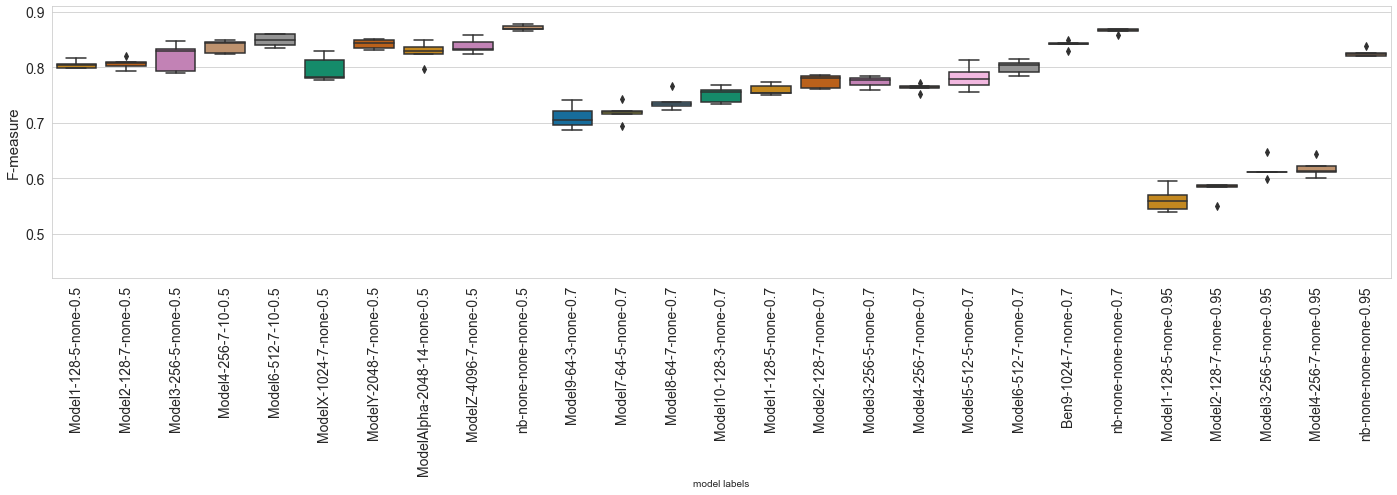

,Avg F-measure,SEM,Count
model labels,,,
Ben9-1024-7-none-0.7,0.841700,0.003199,5
Model1-128-5-none-0.5,0.804973,0.003197,5
Model1-128-5-none-0.7,0.759509,0.004549,5
Model1-128-5-none-0.95,0.561335,0.009904,5
Model10-128-3-none-0.7,0.750801,0.006593,5
Model2-128-7-none-0.5,0.806925,0.004357,5
Model2-128-7-none-0.7,0.774944,0.005454,5
Model2-128-7-none-0.95,0.579203,0.007288,5
Model3-256-5-none-0.5,0.818792,0.011461,5


In [32]:
metric = "F-measure"
params = ["filters", "kernel_size"]
y_lims = [0.42, 0.91] #[0.42, 0.91]
y_ticks_major = [0.5, 0.91]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights", "model suffix", "abundance"]
conf_levels = [0.5, 0.7, 0.95]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-cnn-allmodels-full.svg")
save_loc = None

data_slice = level7_selected_models_weighted[["F-measure", "Precision", "Recall"] + params + other_columns]
data_slice = data_slice.fillna('none')
data_slice["model labels"] = data_slice.apply(generate_model_label, axis=1)

selection1 = (data_slice["model suffix"].isin(['none', '10', 'sg'])) & data_slice["confidence"].isin(conf_levels)
selection2 = data_slice["model name"].isin([f"Model{x}" for x in range(1, 11)] + ["nb", "Ben9"] + ['ModelAlpha', 'ModelX', 'ModelY', 'ModelZ'])
selection3 = ~data_slice["model labels"].isin(["Model4-256-7-none-0.5", "Ben9-1024-7-20-0.7", "Model11-none-none-none-0.7", "Model4-256-7-10-0.25"])

data = data_slice[selection1 & selection2 & selection3]

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, y_lims, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "model labels")

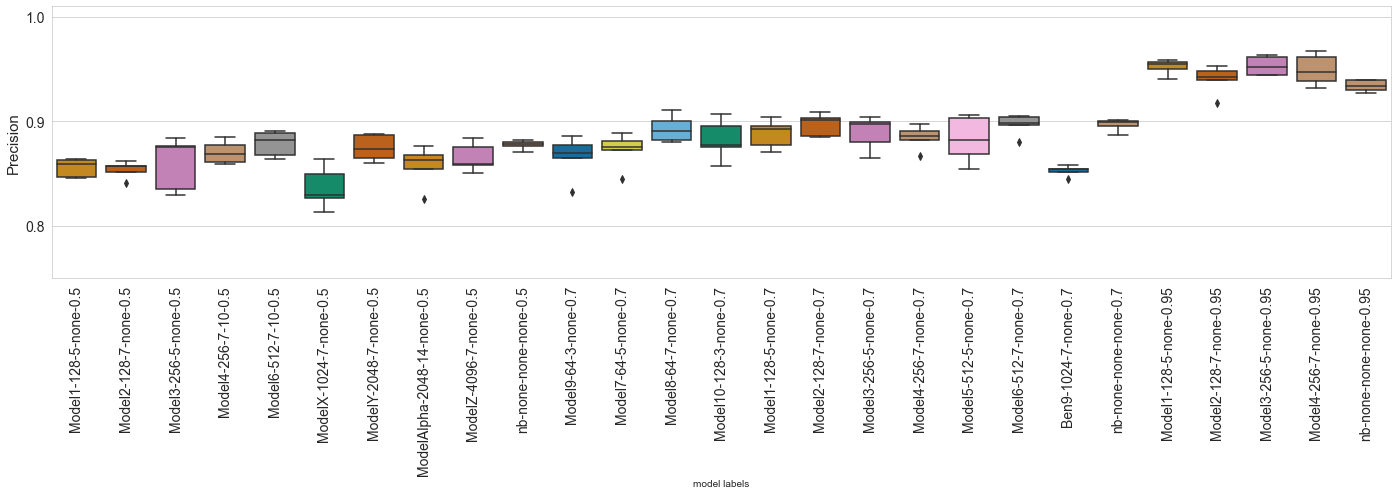

,Avg Precision,SEM,Count
model labels,,,
Ben9-1024-7-none-0.7,0.852853,0.002296,5
Model1-128-5-none-0.5,0.855984,0.003939,5
Model1-128-5-none-0.7,0.888085,0.006156,5
Model1-128-5-none-0.95,0.952277,0.003325,5
Model10-128-3-none-0.7,0.882478,0.008623,5
Model2-128-7-none-0.5,0.853813,0.003516,5
Model2-128-7-none-0.7,0.896835,0.004847,5
Model2-128-7-none-0.95,0.940044,0.006182,5
Model3-256-5-none-0.5,0.860084,0.011328,5


In [33]:
metric = "Precision"
params = ["filters", "kernel_size"]
y_ticks_major = [0.8, 1.01]
y_ticks_minor = False
y_lims = [0.75, 1.01]
other_columns = ["level", "model name", "confidence", "fold", "class weights", "model suffix", "abundance"]
conf_levels = [0.5, 0.7, 0.95]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-cnn-allmodels-full.svg")
save_loc = None

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, y_lims, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "model labels")

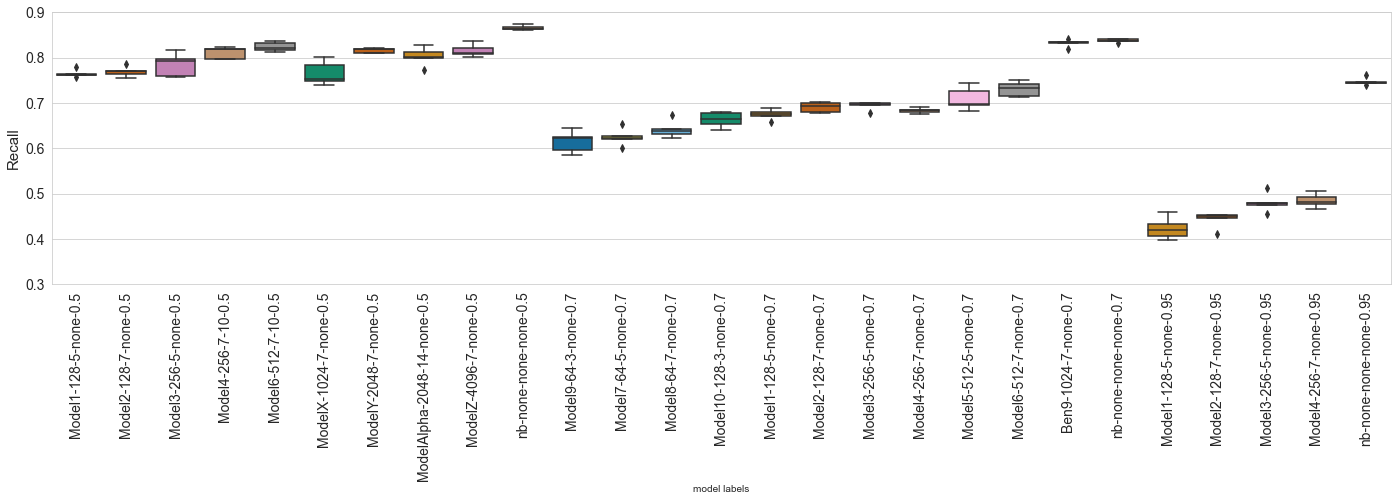

,Avg Recall,SEM,Count
model labels,,,
Ben9-1024-7-none-0.7,0.832649,0.003750,5
Model1-128-5-none-0.5,0.765169,0.003882,5
Model1-128-5-none-0.7,0.674280,0.005255,5
Model1-128-5-none-0.95,0.423332,0.010766,5
Model10-128-3-none-0.7,0.663624,0.007227,5
Model2-128-7-none-0.5,0.769063,0.005027,5
Model2-128-7-none-0.7,0.690805,0.005316,5
Model2-128-7-none-0.95,0.442091,0.008078,5
Model3-256-5-none-0.5,0.784927,0.011626,5


In [34]:
metric = "Recall"
params = ["filters", "kernel_size"]
y_lims = []
y_ticks_major = [0.3, 0.9]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights", "model suffix", "abundance"]
conf_levels = [0.5, 0.7, 0.95]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-cnn-allmodels-full.svg")
save_loc = None

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, y_lims, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "model labels")